#### validation or kfold is not added and also data augmentation is not added yet. Mainly the Ensemble is not performed. Due for tomorrow.

In [1]:
%%capture
!pip install ../input/segmentation-models-wheels/efficientnet_pytorch-0.6.3-py3-none-any.whl
!pip install ../input/segmentation-models-wheels/pretrainedmodels-0.7.4-py3-none-any.whl
!pip install ../input/segmentation-models-wheels/timm-0.3.2-py3-none-any.whl
!pip install ../input/segmentation-models-wheels/segmentation_models_pytorch-0.1.3-py3-none-any.whl

In [2]:
!pip install colorama -q

In [3]:
# import wandb
# from wandb.keras import WandbCallback

# try:
#     from kaggle_secrets import UserSecretsClient
#     user_secrets = UserSecretsClient()
#     api_key = user_secrets.get_secret("WANDB")
#     wandb.login(key=api_key)
#     anonymous = None
# except:
#     anonymous = "must"
#     print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

In [4]:
# wandb.init(project="kaggle_sartorius_unet_ensemble", entity="somusan")

In [5]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score
warnings.filterwarnings("ignore")


def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
fix_all_seeds(2021)


In [6]:
class config:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'Unet-effnetb2-512x512-aug2'
    model_name    = 'Unet'
    backbone0     = 'efficientnet-b2'
    backbone1     = 'efficientnet-b7'
    backbone2     = 'efficientnet-b6'
    backbone3     = 'efficientnet-b5'
    batch_size    = 8
    train_bs      = 24
    valid_bs      = 48
    img_size      = [512, 512]
    epochs        = 5
    lr            = 5e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(100*6*1.8)
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = 32//train_bs
#     n_fold        = 5
    num_classes   = 1
    DEVICE        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    competition   = 'sartorius'
    _wandb_kernel = 'somusan'

In [7]:
from colorama import init,Fore,Style

class PCOLOR:
    init()
    # COLORS
    green = Fore.GREEN
    red = Fore.RED
    blue = Fore.BLUE
    yellow = Fore.YELLOW
    magneta = Fore.MAGENTA
    cyan = Fore.CYAN

    # BRIGHT COLORS
    bgreen = Fore.GREEN + Style.BRIGHT
    bred = Fore.RED + Style.BRIGHT
    bblue = Fore.BLUE + Style.BRIGHT
    byellow = Fore.YELLOW + Style.BRIGHT
    bmagneta = Fore.MAGENTA + Style.BRIGHT
    bcyan = Fore.CYAN + Style.BRIGHT

In [8]:
SAMPLE_SUBMISSION  = '../input/sartorius-cell-instance-segmentation/sample_submission.csv'
TRAIN_CSV = "../input/sartorius-cell-instance-segmentation/train.csv"
TRAIN_PATH = "../input/sartorius-cell-instance-segmentation/train"
TEST_PATH = "../input/sartorius-cell-instance-segmentation/test"

RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

# (336, 336)
IMAGE_RESIZE = (512,512)

LEARNING_RATE = 5e-4
EPOCHS = 50

In [9]:
df_train = pd.read_csv(TRAIN_CSV)
df_train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [10]:
train_img_path = "../input/sartorius-cell-instance-segmentation/train/"
train_mask_path = "../input/sartorius-binary-mask-dataset"

train_img = [train_img_path +i for i in sorted(os.listdir(train_img_path))]
train_mask = [train_mask_path + '/' +i for i in sorted(os.listdir(train_mask_path))]


id_list = []

for i in train_img:
    id_list.append(i.split("/")[-1].split(".")[0])

columns_tup = list(zip(id_list,train_img,train_mask))
df_prep = pd.DataFrame(columns_tup,columns=["id",'img_path','mask_path'])
print(df_prep["img_path"][0])
print(df_prep["mask_path"][0])

df_prep.head()

# plt.imshow(plt.imread(df_prep["img_path"][0]))
# plt.imshow(np.load(df_prep["mask_path"][0]))

../input/sartorius-cell-instance-segmentation/train/0030fd0e6378.png
../input/sartorius-binary-mask-dataset/0030fd0e6378.npy


,id,img_path,mask_path
0,0030fd0e6378,../input/sartorius-cell-instance-segmentation/...,../input/sartorius-binary-mask-dataset/0030fd0...
1,0140b3c8f445,../input/sartorius-cell-instance-segmentation/...,../input/sartorius-binary-mask-dataset/0140b3c...
2,01ae5a43a2ab,../input/sartorius-cell-instance-segmentation/...,../input/sartorius-binary-mask-dataset/01ae5a4...
3,026b3c2c4b32,../input/sartorius-cell-instance-segmentation/...,../input/sartorius-binary-mask-dataset/026b3c2...
4,029e5b3b89c7,../input/sartorius-cell-instance-segmentation/...,../input/sartorius-binary-mask-dataset/029e5b3...


In [11]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(df_train, image_id, input_shape):
    height, width = input_shape
    labels = df_train[df_train["id"] == image_id]["annotation"].tolist()
    mask = np.zeros((height, width))
    for label in labels:
        mask += rle_decode(label, shape=(height, width))
    mask = mask.clip(0, 1)
    return mask

In [12]:
class CellDataset(Dataset):
    def __init__(self, df,transforms):
        self.df = df
        self.base_path = TRAIN_PATH
#         self.transforms = Compose([Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), 
#                                    Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), 
#                                    HorizontalFlip(p=0.5),
#                                    VerticalFlip(p=0.5),
#                                    ToTensorV2()])
        self.transforms = transforms 
        self.gb = self.df.groupby('id')
        self.image_ids = df.id.unique().tolist()

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        df = self.gb.get_group(image_id)
        annotations = df['annotation'].tolist()
        image_path = os.path.join(self.base_path, image_id + ".png")
        
#         image = Image.open(image_path)
        # print("image",image.size)
        
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
#         print("before reshape",image.shape)
#         image = np.reshape(image,(3,512,512))
#         image = image.resize((512,512))
#         print("after reshape",image.shape)
        mask = build_masks(df_train, image_id, input_shape=(520, 704))
        mask = (mask >= 1).astype('float32')
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image'] #.type(torch.LongTensor)
#         print("aug shape",image.shape)
        mask = augmented['mask'] # .type(torch.LongTensor)
#         print(mask.shape)
#         print(image.resize((3,512,512)).shape)
        image = np.reshape(image.numpy(),(3, 512, 512))
        image = torch.from_numpy(image)
#         print("img aug type-->",type(image))
#         print("after aug -->", image.shape)
#         print("mask after aug -->", mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1])).shape)
        return image, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))

    def __len__(self):
        return len(self.image_ids)

In [13]:
train_transform = A.Compose([
        A.Resize(*config.img_size),
        A.CLAHE(p=0.35),
        A.ColorJitter(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=90, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=config.img_size[0]//20, max_width=config.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ToTensorV2()], p=1.0)

valid_transform =  A.Compose([
        A.Resize(*config.img_size),
        ToTensorV2()], p=1.0)

In [14]:
# # ../input/sartorius-cell-instance-segmentation/train/0030fd0e6378.png
# # ../input/sartorius-binary-mask-dataset/0030fd0e6378.npy
# # img = cv2.imread("../input/sartorius-cell-instance-segmentation/train/0030fd0e6378.png")
# # # img = cv2.resize(img,(512,512,3))
# # # img = np.reshape(img,(512,512,3))
# # img = img.resize((IMAGE_RESIZE[0], IMAGE_RESIZE[1]))
# # print(img)
# from PIL import Image
# image = Image.open('./image_name.jpg')
# # print("image",image.size)
# new_image = image.resize((512,512))
# # new_image.size
# new_image

In [15]:
# import requests
# image_url = "https://media.geeksforgeeks.org/wp-content/uploads/20190715202808/ybear3-300x224.jpg"
# img_data = requests.get(image_url).content
# with open('image_name.jpg', 'wb') as handler:
#     handler.write(img_data)
    


In [16]:
from sklearn.model_selection import train_test_split
train_data, valid_data = train_test_split(df_train,test_size = 0.2,random_state=42)


ds_train = CellDataset(train_data,train_transform)
ds_valid = CellDataset(valid_data,valid_transform)

image, mask = ds_valid[1]
# image.shape, mask.shape
# ds_train[0]

In [17]:
# ds_train = ds_train.type(torch.LongTensor)

In [18]:
print("Initializing Datasets and Dataloaders...")

# Creating our dataset
# train_dataset = SkinCancerDataset(csv_file=data_csv_file, root_dir=data_dir, transform=data_transforms['train'])
# print(len(train_dataset))

# train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [4000, 1000])

# Dataloader iterators, make sure to shuffle
train_dataloader = DataLoader(ds_train, batch_size=config.batch_size, shuffle=False,num_workers=4, pin_memory=True)
val_dataloader = DataLoader(ds_valid, batch_size=config.batch_size, shuffle=False,num_workers=4, pin_memory=True)

# Create training and validation dataloaders
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

Initializing Datasets and Dataloaders...


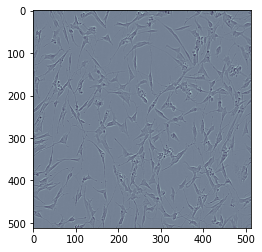

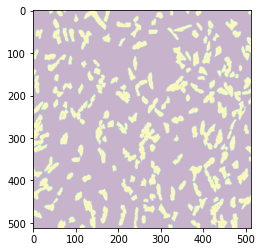

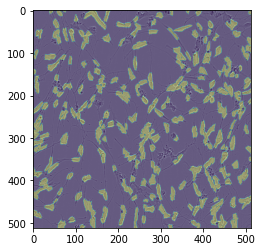

In [19]:
batch = next(iter(val_dataloader))
images, masks = batch

idx=1
plt.imshow(images[idx][0], cmap='bone')
plt.show()
plt.imshow(masks[idx][0], alpha=0.3)
plt.show()
plt.imshow(images[idx][0], cmap='bone')
plt.imshow(masks[idx][0], alpha=0.3)
plt.show()

In [20]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [21]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/pytorch-pretrained-image-models/resnet34.pth /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth

import torch
import collections.abc as container_abcs
torch._six.container_abcs = container_abcs
import segmentation_models_pytorch as smp

In [22]:
model = smp.Unet(config.backbone0, encoder_weights="imagenet", classes=1,activation=None)
# model1 = smp.Unet(config.backbone1, encoder_weights="imagenet", classes=1,activation=None)
# model2 = smp.Unet(config.backbone2, encoder_weights="imagenet", classes=1,activation=None)
# model3 = smp.Unet(config.backbone3, encoder_weights="imagenet", classes=1,activation=None)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

In [23]:
# for i in val_dataloader:
#     print(i.items())
#     break

In [24]:
# def valid_one_step(model,data):
#     for k,v in data.items():
#         data[k] = v.to(config.DEVICE)
#     loss = model(**data)
#     return loss

# def validation_one_epoch(model,data_loader):
#     model.eval()
#     total_loss = 0
#     for batch_index, data in enumerate(data_loader):
#         loss = validation_one_step(model,data)
#         total_loss += loss
#     return loss

In [37]:
def eval_loop(model, criterion, eval_loader, device=config.DEVICE):
    n_batches = len(val_dataloader)
    print(n_batches)
    running_loss = 0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores = [], []
        pbar = tqdm(eval_loader, desc='Iterating over evaluation data')
        for imgs, masks in pbar:
            # pass to device
            imgs = imgs.to(device)
            masks = masks.to(device)
            # forward
            out = model(imgs.float())
            loss = criterion(out, masks)
            running_loss += loss.item()#*imgs.shape[0]
            # calculate predictions using output
            predicted = (out > 0.5).float()
            predicted = predicted.view(-1).cpu().numpy()
            labels = masks.view(-1).cpu().numpy()
            accuracy.append(accuracy_score(labels, predicted))
            f1_scores.append(f1_score(labels, predicted))
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
#     running_loss /= len(eval_loader.sampler)
    epoch_loss = running_loss / n_batches

    return {
        'accuracy':acc,
        'f1_macro':f1, 
        'loss':running_loss}

In [41]:
# torch.set_default_tensor_type("torch.cuda.FloatTensor")
n_batches = len(train_dataloader)

# model1.cuda()
model.to(config.DEVICE)
model.train()

criterion = MixedLoss(10.0, 2.0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)



for epoch in range(1, EPOCHS + 1):
    print(f"Starting epoch: {epoch} / {EPOCHS}")
    running_loss = 0.0
    optimizer.zero_grad()
    
    accuracy, f1_scores = [], []
    for batch_idx, batch in enumerate(train_dataloader):
        
        
        images, masks = batch
        images, masks = images.to(config.DEVICE),  masks.to(config.DEVICE)
        
        outputs = model(images.float())
        loss = criterion(outputs, masks)
        
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        predicted = predicted.view(-1).cpu().numpy()
        labels = masks.view(-1).cpu().numpy()
        accuracy.append(accuracy_score(labels, predicted))
        f1_scores.append(f1_score(labels, predicted))
    
    val_eval = eval_loop(model,criterion,val_dataloader)
#     print(type(val_eval))
#     print(val_eval["loss"])
#     print(val_eval["accuracy"])
#     print(val_eval["f1_macro"])
    val_loss = val_eval["loss"]
    val_acc = val_eval["accuracy"]
    val_f1 = val_eval["f1_macro"]

    epoch_loss = running_loss / n_batches
    epoch_acc = sum(accuracy)/len(accuracy)
    epoch_f1 = sum(f1_scores)/len(f1_scores)
    
    print(f"Epoch: {epoch} - Train Loss {epoch_loss:.4f} - Train acc {epoch_acc:.4f} - Train f1 {epoch_f1:.4f}")
    print(f"Epoch: {epoch} - Validation Loss {val_loss} - Validation acc {val_acc} - Validation f1 {val_f1}")    

Starting epoch: 1 / 50
Epoch: 1 - Train Loss 2.0204 - Train acc 0.9063 - Train f1 0.4789
Epoch: 1 - Validation Loss 206.17369174957275 - Validation acc 0.8958775011698404 - Validation f1 0.0615851122014501
Starting epoch: 2 / 50
75


Iterating over evaluation data:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 2 - Train Loss 2.3461 - Train acc 0.8901 - Train f1 0.2024
Epoch: 2 - Validation Loss 230.7930784225464 - Validation acc 0.9050626754760742 - Validation f1 0.28824853104240156
Starting epoch: 3 / 50
75


Iterating over evaluation data:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 3 - Train Loss 2.0172 - Train acc 0.9095 - Train f1 0.4011
Epoch: 3 - Validation Loss 155.09310936927795 - Validation acc 0.9149442354838053 - Validation f1 0.49339884098260467
Starting epoch: 4 / 50


KeyboardInterrupt: 

In [ ]:
# class sartorius_dataset():
#     def __init__(self,df,transforms):
#         self.df = df
#         self.img_path = df["img_path"].values()
#         self.mask_path = df["mask_path"].values()
#         self.transforms = transforms
#     def __len__(self):
#         return len(self.df)
#     def __getitem__(self,idx):
#         img_file = self.img_path[idx]
#         img = cv2.imread(img_file,cv2.IMREAD_COLOR)
#         mask_file = self.mask_path[idx]
#         mask = np.load(mask_file)
#         data = self.transforms(image = img,mask=mask)
#         mask = data["mask"]
#         mask = np.expand_dims(mask,axis=0)
#         return data["image"], mask
    

In [ ]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
#         self.img_paths = df["img_path"].values()
        self.img_paths = np.array(df['img_path'])
        try: # if there is no mask then only send images --> test data
#             self.mask_paths = df["mask_path"].values()
            self.msk_paths = np.array(df['mask_path'])

        except:
            self.msk_paths  = None
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img      = cv2.imread(img_path,cv2.IMREAD_COLOR)
        if self.msk_paths is not None:
            msk_path = self.msk_paths[index]
            msk      = np.load(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            msk      = np.expand_dims(msk, axis=0) # output_shape: (batch_size, 1, img_size, img_size)
            return img, msk
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            return img

In [ ]:
# class CellDataset(Dataset):
#     def __init__(self, df):
#         self.df = df
#         self.base_path = TRAIN_PATH
#         self.transforms = Compose([Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), 
#                                    Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), 
#                                    HorizontalFlip(p=0.5),
#                                    VerticalFlip(p=0.5),
#                                    ToTensorV2()])
#         self.gb = self.df.groupby('id')
#         self.image_ids = df.id.

In [ ]:
unique().tolist()

#     def __getitem__(self, idx):
#         image_id = self.image_ids[idx]
#         df = self.gb.get_group(image_id)
#         annotations = df['annotation'].tolist()
#         image_path = os.path.join(self.base_path, image_id + ".png")
#         image = cv2.imread(image_path)
#         mask = build_masks(df_train, image_id, input_shape=(520, 704))
#         mask = (mask >= 1).astype('float32')
#         augmented = self.transforms(image=image, mask=mask)
#         image = augmented['image']
#         mask = augmented['mask']
#         return image, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))

#     def __len__(self):
#         return len(self.image_ids)

In [ ]:
train_transform = A.Compose([
        A.Resize(*config.img_size),
        A.CLAHE(p=0.35),
        A.ColorJitter(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=90, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=config.img_size[0]//20, max_width=config.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ToTensorV2()], p=1.0)

valid_transform =  A.Compose([
        A.Resize(*config.img_size),
        ToTensorV2()], p=1.0)

In [ ]:
from sklearn.model_selection import train_test_split
train_data, valid_data = train_test_split(df_prep,test_size = 0.2,random_state=42)


ds_train = BuildDataset(train_data,train_transform)
ds_valid = BuildDataset(valid_data,valid_transform)

image, mask = ds_valid[1]
image.shape, mask.shape
# ds_train[0]

In [ ]:
print("Initializing Datasets and Dataloaders...")

# Creating our dataset
# train_dataset = SkinCancerDataset(csv_file=data_csv_file, root_dir=data_dir, transform=data_transforms['train'])
# print(len(train_dataset))

# train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [4000, 1000])

# Dataloader iterators, make sure to shuffle
train_dataloader = DataLoader(ds_train, batch_size=config.batch_size, shuffle=False,num_workers=4, pin_memory=True)
val_dataloader = DataLoader(ds_valid, batch_size=config.batch_size, shuffle=False,num_workers=4, pin_memory=True)

# Create training and validation dataloaders
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

In [ ]:
dataloaders_dict

In [ ]:
plt.imshow(image[0], cmap='bone')
plt.show()
plt.imshow(mask[0], alpha=0.3)
plt.show()

In [ ]:
# dl_train = DataLoader(ds_train, batch_size=64, num_workers=4, pin_memory=True, shuffle=False)

In [ ]:
len(val_dataloader)

In [ ]:
batch = next(iter(val_dataloader))
images, masks = batch

In [ ]:
idx=1
plt.imshow(images[idx][0], cmap='bone')
plt.show()
plt.imshow(masks[idx][0], alpha=0.3)
plt.show()
plt.imshow(images[idx][0], cmap='bone')
plt.imshow(masks[idx][0], alpha=0.3)
plt.show()

In [ ]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [ ]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/pytorch-pretrained-image-models/resnet34.pth /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth

import torch
import collections.abc as container_abcs
torch._six.container_abcs = container_abcs
import segmentation_models_pytorch as smp

# U-Net

In [ ]:
model = smp.Unet(config.backbone0, encoder_weights="imagenet", classes=1,activation=None)
model1 = smp.Unet(config.backbone1, encoder_weights="imagenet", classes=1,activation=None)
model2 = smp.Unet(config.backbone2, encoder_weights="imagenet", classes=1,activation=None)
model3 = smp.Unet(config.backbone3, encoder_weights="imagenet", classes=1,activation=None)

In [ ]:
# Check model details
# model

## Model0

In [ ]:
from torch.utils.tensorboard import SummaryWriter
def train_loop(model, optimizer, criterion, train_loader, device=config.DEVICE):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    for imgs, masks in pbar:
        # pass to device
        imgs = imgs.to(device)
        masks = masks.to(device)
        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item()*imgs.shape[0]  # += loss * current batch size
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader.sampler)
    return running_loss


def eval_loop(model, criterion, eval_loader, device=config.DEVICE):
    running_loss = 0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores = [], []
        pbar = tqdm(eval_loader, desc='Iterating over evaluation data')
        for imgs, masks in pbar:
            # pass to device
            imgs = imgs.to(device)
            masks = masks.to(device)
            # forward
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item()*imgs.shape[0]
            # calculate predictions using output
            predicted = (out > 0.5).float()
            predicted = predicted.view(-1).cpu().numpy()
            labels = masks.view(-1).cpu().numpy()
            accuracy.append(accuracy_score(labels, predicted))
            f1_scores.append(f1_score(labels, predicted))
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    running_loss /= len(eval_loader.sampler)
    return {
        'accuracy':acc,
        'f1_macro':f1, 
        'loss':running_loss}


def train(model, optimizer, criterion, train_loader, valid_loader,
          device=config.DEVICE, 
          num_epochs=30, 
          valid_loss_min=np.inf,
          logdir='logdir'):
    
    tb_writer = SummaryWriter(log_dir=logdir)
    for e in range(num_epochs):
        # train for epoch
        train_loss = train_loop(
            model, optimizer, criterion, train_loader, device=device)
        # evaluate on validation set
        metrics = eval_loop(
            model, criterion, valid_loader, device=device
        )
        # show progress
        print_string = f'Epoch: {e+1} '
        print_string+= f'TrainLoss: {train_loss:.5f} '
        print_string+= f'ValidLoss: {metrics["loss"]:.5f} '
        print_string+= f'ACC: {metrics["accuracy"]:.5f} '
        print_string+= f'F1: {metrics["f1_macro"]:.3f}'
        print(print_string)

        # Tensorboards Logging
        tb_writer.add_scalar('UNet/Train Loss', train_loss, e)
        tb_writer.add_scalar('UNet/Valid Loss', metrics["loss"], e)
        tb_writer.add_scalar('UNet/Accuracy', metrics["accuracy"], e)
        tb_writer.add_scalar('UNet/F1 Macro', metrics["f1_macro"], e)

        # save the model 
        if metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), 'UNet.pt')
            valid_loss_min = metrics["loss"]
            
            
# set_seed(21)
# model = UNet(3, 1).to(device)
model.to(device=config.DEVICE)
optimizer = optim.Adam(model.parameters(), lr=config.lr)
criterion = MixedLoss(10.0, 2.0)
train(model, optimizer, criterion, train_dataloader, val_dataloader)

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])


def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
        
        
# model = UNET(in_channels=3, out_channels=1).to(config.DEVICE)
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = MixedLoss(10.0, 2.0)
optimizer = optim.Adam(model.parameters(), lr=config.lr)

# train_loader, val_loader = get_loaders(
#     TRAIN_IMG_DIR,
#     TRAIN_MASK_DIR,
#     VAL_IMG_DIR,
#     VAL_MASK_DIR,
#     BATCH_SIZE,
#     train_transform,
#     val_transforms,
#     NUM_WORKERS,
#     PIN_MEMORY,
# )

# if LOAD_MODEL:
#     load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


# check_accuracy(val_loader, model, device=DEVICE)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

    # print some examples to a folder
    save_predictions_as_imgs(
        val_loader, model, folder="saved_images/", device=DEVICE
    )

In [ ]:
# from torch.multiprocessing import Pool, Process, set_start_method
# try:
#      set_start_method('spawn', force=True)
# # except RuntimeError:
#     pass

torch.set_default_tensor_type("torch.cuda.FloatTensor")
n_batches = len(train_dataloader)
# torch.multiprocessing.set_start_method('spawn')
model.to(device=DEVICE)
model.train()

criterion = MixedLoss(10.0, 2.0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(1, EPOCHS + 1):
    print(f"Starting epoch: {epoch} / {EPOCHS}")
    running_loss = 0.0
    optimizer.zero_grad()
    
    for batch_idx, batch in enumerate(train_dataloader):
        
        # Predict
        images, masks = batch
        images, masks = images.cuda(),  masks.cuda()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Back prop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    epoch_loss = running_loss / n_batches
    print(f"Epoch: {epoch} - Train Loss {epoch_loss:.4f}")

In [ ]:
FILE = "./model0_50.pth"
torch.save(model.state_dict(), FILE)

wandb.save("./model0_50.pth")
# print(model.state_dict())
# loaded_model = Model(n_input_features=6)
# loaded_model.load_state_dict(torch.load(FILE)) # it takes the loaded dictionary, not the path file itself
# loaded_model.eval()

### Model1

In [ ]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")
n_batches = len(dl_train)

model1.cuda()
model1.train()

criterion = MixedLoss(10.0, 2.0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(1, EPOCHS + 1):
    print(f"Starting epoch: {epoch} / {EPOCHS}")
    running_loss = 0.0
    optimizer.zero_grad()
    
    for batch_idx, batch in enumerate(dl_train):
        
        
        images, masks = batch
        images, masks = images.cuda(),  masks.cuda()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    epoch_loss = running_loss / n_batches
    print(f"Epoch: {epoch} - Train Loss {epoch_loss:.4f}")

In [ ]:
FILE1 = "./model1_50.pth"
torch.save(model1.state_dict(), FILE1)

wandb.save("./model1_50.pth")

## Model2

In [ ]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")
n_batches = len(dl_train)

model2.cuda()
model3.train()

criterion = MixedLoss(10.0, 2.0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(1, EPOCHS + 1):
    print(f"Starting epoch: {epoch} / {EPOCHS}")
    running_loss = 0.0
    optimizer.zero_grad()
    
    for batch_idx, batch in enumerate(dl_train):
        
        
        images, masks = batch
        images, masks = images.cuda(),  masks.cuda()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    epoch_loss = running_loss / n_batches
    print(f"Epoch: {epoch} - Train Loss {epoch_loss:.4f}")

In [ ]:
FILE2 = "./model2_50.pth"
torch.save(model2.state_dict(), FILE2)

wandb.save("./model2_50.pth")

## model3

In [ ]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")
n_batches = len(dl_train)

model3.cuda()
model3.train()

criterion = MixedLoss(10.0, 2.0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(1, EPOCHS + 1):
    print(f"Starting epoch: {epoch} / {EPOCHS}")
    running_loss = 0.0
    optimizer.zero_grad()
    
    for batch_idx, batch in enumerate(dl_train):
        
        # Predict
        images, masks = batch
        images, masks = images.cuda(),  masks.cuda()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Back prop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    epoch_loss = running_loss / n_batches
    print(f"Epoch: {epoch} - Train Loss {epoch_loss:.4f}")

In [ ]:
FILE3 = "./model3_50.pth"
torch.save(model3.state_dict(), FILE3)

wandb.save("./model3_50.pth")

# Predict

In [ ]:
class TestCellDataset(Dataset):
    def __init__(self):
        self.test_path = TEST_PATH
        
        
        self.image_ids = [f[:-4]for f in os.listdir(self.test_path)]
        self.num_samples = len(self.image_ids)
        self.transform = Compose([Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), ToTensorV2()])

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        path = os.path.join(self.test_path, image_id + ".png")
        image = cv2.imread(path)
        image = self.transform(image=image)['image']
        return {'image': image, 'id': image_id}

    def __len__(self):
        return self.num_samples

In [ ]:
del dl_train, ds_train, optimizer

In [ ]:
ds_test = TestCellDataset()
dl_test = DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

### Utilities

In [ ]:
def post_process(probability, threshold=0.5, min_size=300):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = []
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            a_prediction = np.zeros((520, 704), np.float32)
            a_prediction[p] = 1
            predictions.append(a_prediction)
    return predictions


def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

In [ ]:
pd.read_csv(SAMPLE_SUBMISSION)

In [ ]:
def check_is_run_length(mask_rle):
    if not mask_rle:
        return True
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    start_prev = starts[0]
    ok = True
    for start in starts[1:]:
        ok = ok and start > start_prev
        start_prev = start
        if not ok:
            return False
    return True

def create_empty_submission():
    fs = os.listdir("../input/sartorius-cell-instance-segmentation/test")
    df = pd.DataFrame([(f[:-4], "") for f in fs], columns=['id', 'predicted'])
    df.to_csv("submission.csv", index=False)

In [ ]:
model.eval()

submission = []
for i, batch in enumerate(tqdm(dl_test)):
    preds = torch.sigmoid(model(batch['image'].cuda()))
    preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
    for image_id, probability_mask in zip(batch['id'], preds):
        try:
            #if probability_mask.shape != IMAGE_RESIZE:
            #    probability_mask = cv2.resize(probability_mask, dsize=IMAGE_RESIZE, interpolation=cv2.INTER_LINEAR)
            probability_mask = cv2.resize(probability_mask, dsize=(704, 520), interpolation=cv2.INTER_LINEAR)
            predictions = post_process(probability_mask)
            for prediction in predictions:
                #plt.imshow(prediction)
                #plt.show()
                try:
                    submission.append((image_id, rle_encoding(prediction)))
                except:
                    print("Error in RL encoding")
        except Exception as e:
            print(f"Exception for img: {image_id}: {e}")
        
        # Fill images with no predictions
        image_ids = [image_id for image_id, preds in submission]
        if image_id not in image_ids:
            submission.append((image_id, ""))
            
df_submission = pd.DataFrame(submission, columns=['id', 'predicted'])
df_submission.to_csv('submission.csv', index=False)

if df_submission['predicted'].apply(check_is_run_length).mean() != 1:
    print("Check run lenght failed")
    create_empty_submission()

In [ ]:
!rm -r ./wandb